In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import catboost as cat_
import lightgbm as lgb
from sklearn import preprocessing

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [6]:
ntrain = train.shape[0]
ntest = test.shape[0]
combine = pd.concat((train, test)).reset_index(drop=True)

In [7]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# Find percent of missing variables
def percent_missing(data):
    for a in data.columns:
        print(a + " missing: " + str(float(100 - (data[a].count()/len(data)*100))) + "%")
percent_missing(combine)

PassengerId missing: 0.0%
Survived missing: 31.932773109243698%
Pclass missing: 0.0%
Name missing: 0.0%
Sex missing: 0.0%
Age missing: 20.0916730328495%
SibSp missing: 0.0%
Parch missing: 0.0%
Ticket missing: 0.0%
Fare missing: 0.07639419404125647%
Cabin missing: 77.46371275783041%
Embarked missing: 0.15278838808249873%


In [7]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [8]:
combine.Cabin.value_counts()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F2                 4
B96 B98            4
                  ..
E77                1
E17                1
D40                1
A10                1
B37                1
Name: Cabin, Length: 186, dtype: int64

In [9]:
identifier = test['PassengerId']
#identifier

In [10]:
# Let's drop PassengerId
combine.drop(['PassengerId'], axis=1, inplace=True)
combine.shape

(1309, 11)

<AxesSubplot:xlabel='Survived', ylabel='count'>

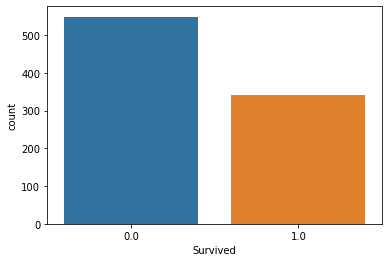

In [11]:
# Target - Survived
sns.countplot(x='Survived', data=combine)

An imbalanced dataset showing most people did not survive

In [12]:
combine.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [11]:
# Break down Name feature to extract title
combine['Title'] = (combine['Name'].str.split(".", expand=True)[0].str.split(",", expand=True)[1].str.split(" ", expand=True)[1])
combine['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [12]:
combine.isnull().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
Title          0
dtype: int64

In [13]:
# Fill Embarked column with a new category NONE
combine.Embarked.fillna("NONE", axis=0, inplace=True)

In [14]:
# Fill Cabin column with a new category NONE
combine.Cabin.fillna("NONE", axis=0, inplace=True)

In [25]:
combine[['Age', 'Title']].head()

,Age,Title
0,22.0,Mr
1,38.0,Mrs
2,26.0,Miss
3,35.0,Mrs
4,35.0,Mr


In [26]:
combine[combine['Title'] == "Master"].Age.min()

0.33

In [15]:
combine["MeanAge"] = combine.groupby("Title")["Age"].transform("mean")
combine.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,MeanAge
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NONE,S,Mr,32.252151
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,36.994118
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NONE,S,Miss,21.774238
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,36.994118
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NONE,S,Mr,32.252151


In [16]:
# Fill missing age with the mean value corresponding to the passengers' title
combine.loc[combine.Age.isnull(), "Age"] = combine.loc[combine.Age.isnull(), "MeanAge"]

<AxesSubplot:xlabel='Fare'>

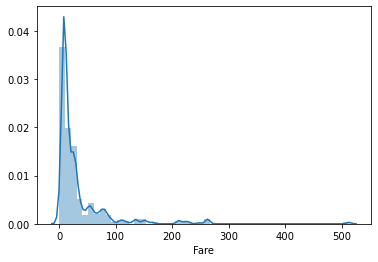

In [29]:
sns.distplot(combine['Fare'])

In [30]:
combine[combine.Fare.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,MeanAge
1043,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NONE,S,Mr,32.252151


In [31]:
combine.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [32]:
# Get an idea of the passenger's fare w.r.t the class
combine[['Pclass', 'Fare']].head(10)

,Pclass,Fare
0,3,7.2500
1,1,71.2833
2,3,7.9250
3,1,53.1000
4,3,8.0500
5,3,8.4583
6,1,51.8625
7,3,21.0750
8,3,11.1333
9,2,30.0708


In [17]:
pclass_mapping = {
    1: 'First Class',
    2: 'Second Class',
    3: 'Third Class'
}
combine.loc[:, "PClassMap"] = combine.Pclass.map(pclass_mapping)

In [18]:
combine["MeanFare"] = combine.groupby("PClassMap")["Fare"].transform("mean")
combine.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,MeanAge,PClassMap,MeanFare
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NONE,S,Mr,32.252151,Third Class,13.302889
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,36.994118,First Class,87.508992
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NONE,S,Miss,21.774238,Third Class,13.302889
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,36.994118,First Class,87.508992
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NONE,S,Mr,32.252151,Third Class,13.302889


In [19]:
# Fill missing fare with the mean value corresponding to the passengers' class
combine.loc[combine.Fare.isnull(), "Fare"] = combine.loc[combine.Fare.isnull(), "MeanFare"]

In [20]:
combine.isnull().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
MeanAge        0
PClassMap      0
MeanFare       0
dtype: int64

<AxesSubplot:>

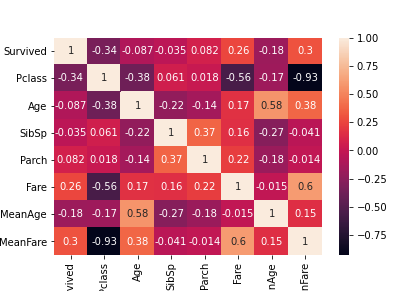

In [37]:
#print(combine.corr())
sns.heatmap(combine.corr(), annot=True)

<AxesSubplot:xlabel='Embarked', ylabel='count'>

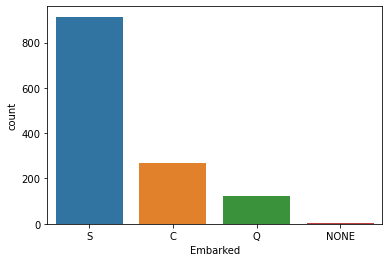

In [38]:
sns.countplot(x='Embarked', data=combine)

<AxesSubplot:xlabel='Title', ylabel='count'>

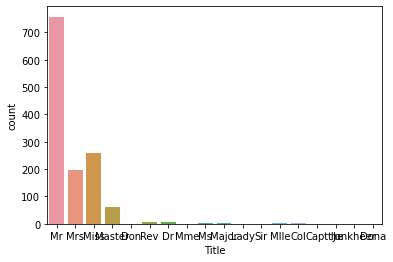

In [21]:
sns.countplot(x='Title', data=combine)

In [22]:
# Let's drop Name
combine.drop(['Name'], axis = 1, inplace=True)

In [23]:
combine.drop(['MeanFare', 'MeanAge', 'PClassMap'], axis=1, inplace=True)

In [24]:
combine['Family'] = combine['SibSp'] + combine['Parch'] + 1

In [25]:
combine.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [26]:
combine.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Family
0,0.0,3,male,22.0,A/5 21171,7.2500,NONE,S,Mr,2
1,1.0,1,female,38.0,PC 17599,71.2833,C85,C,Mrs,2
2,1.0,3,female,26.0,STON/O2. 3101282,7.9250,NONE,S,Miss,1
3,1.0,1,female,35.0,113803,53.1000,C123,S,Mrs,2
4,0.0,3,male,35.0,373450,8.0500,NONE,S,Mr,1


In [27]:
combine.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Ms            2
Major         2
Mlle          2
Sir           1
Lady          1
Jonkheer      1
Capt          1
Mme           1
the           1
Don           1
Dona          1
Name: Title, dtype: int64

In [29]:
combine.loc[combine["Title"].value_counts()[combine["Title"]].values < 10, "Title"] = "RARE"

In [30]:
combine.Title.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
RARE       34
Name: Title, dtype: int64

In [41]:
combine.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Family
0,0.0,3,male,22.0,A/5 21171,7.2500,NONE,S,Mr,2
1,1.0,1,female,38.0,PC 17599,71.2833,C85,C,Mrs,2
2,1.0,3,female,26.0,STON/O2. 3101282,7.9250,NONE,S,Miss,1
3,1.0,1,female,35.0,113803,53.1000,C123,S,Mrs,2
4,0.0,3,male,35.0,373450,8.0500,NONE,S,Mr,1


In [42]:
enc_combine = combine.copy()

In [43]:
features_to_label_encode = ['Ticket', 'Cabin']
for col in features_to_label_encode:
    # initialize label encoder for each features
    lbl = preprocessing.LabelEncoder()
    # fit label encoder on all data
    lbl.fit(enc_combine[col])
    # transform all the data
    enc_combine.loc[:, col] = lbl.transform(enc_combine[col])

In [45]:
enc_combine = pd.get_dummies(enc_combine, drop_first=True)

In [46]:
enc_combine.head()

,Survived,Pclass,Age,Ticket,Fare,Cabin,Family,Sex_male,Embarked_NONE,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_RARE
0,0.0,3,22.0,720,7.2500,185,2,1,0,0,1,0,1,0,0
1,1.0,1,38.0,816,71.2833,106,2,0,0,0,0,0,0,1,0
2,1.0,3,26.0,914,7.9250,185,1,0,0,0,1,1,0,0,0
3,1.0,1,35.0,65,53.1000,70,2,0,0,0,1,0,0,1,0
4,0.0,3,35.0,649,8.0500,185,1,1,0,0,1,0,1,0,0


In [68]:
enc_combine["Pclass*Fare"] = np.multiply(enc_combine["Pclass"], enc_combine["Fare"])
enc_combine["Fare/Pclass"] = enc_combine["Fare"] / enc_combine["Pclass"]

In [69]:
enc_combine.head()

,Survived,Pclass,Age,Ticket,Fare,Cabin,Family,Sex_male,Embarked_NONE,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_RARE,Pclass*Fare,Fare/Pclass
0,0.0,3,22.0,720,7.2500,185,2,1,0,0,1,0,1,0,0,21.7500,2.416667
1,1.0,1,38.0,816,71.2833,106,2,0,0,0,0,0,0,1,0,71.2833,71.283300
2,1.0,3,26.0,914,7.9250,185,1,0,0,0,1,1,0,0,0,23.7750,2.641667
3,1.0,1,35.0,65,53.1000,70,2,0,0,0,1,0,0,1,0,53.1000,53.100000
4,0.0,3,35.0,649,8.0500,185,1,1,0,0,1,0,1,0,0,24.1500,2.683333


In [44]:
enc_combine.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Family
0,0.0,3,male,22.0,720,7.2500,185,S,Mr,2
1,1.0,1,female,38.0,816,71.2833,106,C,Mrs,2
2,1.0,3,female,26.0,914,7.9250,185,S,Miss,1
3,1.0,1,female,35.0,65,53.1000,70,S,Mrs,2
4,0.0,3,male,35.0,649,8.0500,185,S,Mr,1


In [75]:
# Frequency Encoding
# fe = combine.groupby('Title').size()/len(combine)
# combine.loc[: , 'Title'] = combine['Title'].map(fe)

## Baseline Model

In [43]:
baseline_combine = combine.copy()

In [45]:
baseline_combine.drop("PClassMap", axis=1, inplace=True)

### Label Encode Features

In [49]:
features_to_label_encode = ['Ticket', 'Cabin', 'Title']
for col in features_to_label_encode:
    # initialize label encoder for each features
    lbl = preprocessing.LabelEncoder()
    # fit label encoder on all data
    lbl.fit(baseline_combine[col])
    # transform all the data
    baseline_combine.loc[:, col] = lbl.transform(baseline_combine[col])

### One-hot Encode Features

In [51]:
baseline_combine = pd.get_dummies(baseline_combine, drop_first=True)

In [52]:
baseline_combine.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,MeanAge,MeanFare,Sex_male,Embarked_NONE,Embarked_Q,Embarked_S
0,0.0,3,22.0,1,0,720,7.2500,185,12,32.252151,13.302889,1,0,0,1
1,1.0,1,38.0,1,0,816,71.2833,106,13,36.994118,87.508992,0,0,0,0
2,1.0,3,26.0,0,0,914,7.9250,185,9,21.774238,13.302889,0,0,0,1
3,1.0,1,35.0,1,0,65,53.1000,70,13,36.994118,87.508992,0,0,0,1
4,0.0,3,35.0,0,0,649,8.0500,185,12,32.252151,13.302889,1,0,0,1


In [70]:
train = enc_combine[:ntrain].copy() 
#train.drop_duplicates(inplace = True, ignore_index=True)
target = train.Survived.copy()
train.drop('Survived', axis=1, inplace=True)

test = enc_combine[ntrain:].copy()
test.drop('Survived', axis=1, inplace=True)
test = test.reset_index(drop=True)

## Cross-validation

In [48]:
def metric(y, pred):
    return accuracy_score(y, pred)

In [49]:
from sklearn import model_selection

In [71]:
# Specify number of folds
n_folds = 5
kf = StratifiedKFold(n_folds)

seed = 2050

## Manually tweak the hyperparameter, learning rate and n_estimators especially
# params = {
#     'n_estimators': 4000,
#     'learning_rate': 0.01,
#     'objective': 'CrossEntropy',
#     'eval_metric':'AUC',
#     'random_seed': seed,
#     'early_stopping_rounds': 200,
#     'use_best_model': True,
# }
params = {
    'n_estimators': 1000,
    'max_depth': 9,
    'criterion': 'gini'
}

In [269]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [72]:
score_list = []
score = 0
test_oofs = []

for i, (train_index, test_index) in enumerate(kf.split(train, target)):

    # The usual cross validation
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # classifier = RandomForestClassifier()
    
    # model = model_selection.GridSearchCV(
    #     estimator = classifier,
    #     param_grid = params,
    #     scoring= 'accuracy',
    #     verbose= 10
    # )

    # model = CatBoostClassifier(**params)
    model = RandomForestClassifier(**params)
    # model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    model.fit(X_train, y_train)
    
    p = model.predict(X_test)
    sc = metric(y_test, p)
    score_list.append(sc)
    score += sc/n_folds # average score

    pred = model.predict(test)

    test_oofs.append(pred.astype(int))

    print('Fold {} : {}'.format(i, sc))

print()
print()
print('Avg log : ', score)

Fold 0 : 0.8379888268156425
Fold 1 : 0.8146067415730337
Fold 2 : 0.8764044943820225
Fold 3 : 0.8314606741573034
Fold 4 : 0.8539325842696629


Avg log :  0.842878664239533


In [194]:
cat_prediction = pd.DataFrame(test_oofs).T # Transpose
cat_prediction.columns = ['fold_'+ str(i) for i in range(1, n_folds + 1)]

In [195]:
cat_prediction.head()

,fold_1,fold_2,fold_3,fold_4,fold_5
0,0,0,0,0,0
1,1,0,0,0,0
2,0,0,0,0,0
3,1,1,1,1,0
4,0,1,1,1,0


In [64]:
def threshold(a, v):
    # param a: list to apply threshold on
    # param v: threshold value
    for i in range(len(a)):
        if a[i] > v:
            a[i] = 1
            # any value greater than this is taken as 1
        else:
            a[i] = 0
    return a

In [75]:
submission = pd.DataFrame({
        'PassengerId': identifier,
        'Survived': (threshold(np.mean(test_oofs, axis = 0), 0.4)).astype(int)
    })
submission.to_csv('titanic_feat_1d(ratio).csv', index=False)

Baseline gave an accuracy of 78% on the leaderboard!
It will be improved by feature engineering.

## Blending

In [19]:
pred0 = pd.read_csv('t_blending_2.csv')['Survived']
pred1 = pd.read_csv('titanic_feat_1c(ratio).csv')['Survived']
pred2 = pd.read_csv('titanic_cv_random_for_1.csv')['Survived']
pred3 = pd.read_csv('titanic_cv_le_1.csv')['Survived']
pred4 = pd.read_csv('titanic_cv_6t.csv')['Survived']
pred5 = pd.read_csv('titanic_cv_5t.csv')['Survived']
pred6 = pd.read_csv('titanic_cv_3t.csv')['Survived']
pred_final = 0.20*pred0 + 0.18*pred1 + 0.16*pred2 + 0.14*pred3 + 0.12*pred4 + 0.11*pred5 + 0.09*pred6

In [33]:
pred0 = pd.read_csv('t_blending_4.csv')['Survived']
pred1 = pd.read_csv('t_blending_3.csv')['Survived']
pred_f = 0.5*pred0 + 0.5*pred1

In [37]:
import random

In [51]:
fil_list = []
for f in pred_f:
    if f != 0.5:
        fil_list.append(f)
    else:
        fil_list.append(random.choice([0,1]))

In [57]:
sub_list = []
for f in fil_list:
    sub_list.append(int(f))

In [77]:
rand = pred_f.apply(lambda x: random.choice([1,0]) if x == 0.5 else x)
rand

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
413    0.0
414    1.0
415    0.0
416    0.0
417    0.0
Name: Survived, Length: 418, dtype: float64

In [79]:
rand.apply(lambda x: int(x))

0      0
1      0
2      0
3      0
4      0
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: int64

In [78]:
for f in rand:
    if f == 0.5:
        print(f)

In [80]:
submission = pd.DataFrame({
        'PassengerId': identifier,
        'Survived': rand.apply(lambda x: int(x))
    })
submission.to_csv('t_final_3.csv', index=False)

In [244]:
submission = pd.DataFrame({
        'PassengerId': identifier,
        'Survived': pred.astype(int)
    })
submission.to_csv('blend_1.csv', index=False)

In [155]:
baseline_combine.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,MeanAge,MeanFare,Sex_male,Embarked_NONE,Embarked_Q,Embarked_S
0,0.0,3,22.0,1,0,720,7.2500,185,12,32.252151,13.302889,1,0,0,1
1,1.0,1,38.0,1,0,816,71.2833,106,13,36.994118,87.508992,0,0,0,0
2,1.0,3,26.0,0,0,914,7.9250,185,9,21.774238,13.302889,0,0,0,1
3,1.0,1,35.0,1,0,65,53.1000,70,13,36.994118,87.508992,0,0,0,1
4,0.0,3,35.0,0,0,649,8.0500,185,12,32.252151,13.302889,1,0,0,1


## Proper Feature Engineering

In [61]:
combine.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,MeanAge,PClassMap,MeanFare
0,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NONE,S,Mr,32.252151,Third Class,13.302889
1,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,36.994118,First Class,87.508992
2,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NONE,S,Miss,21.774238,Third Class,13.302889
3,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,36.994118,First Class,87.508992
4,0.0,3,male,35.0,0,0,373450,8.0500,NONE,S,Mr,32.252151,Third Class,13.302889


In [62]:
# Features with binary variable can be aggregated using count
family_features = ['SibSp', 'Parch']
combine['Family'] = combine[family_features].sum(axis=1)

In [65]:
# Combine cat features (with possible interaction)
combine["Cabin_PClassMap"] = combine["Cabin"] + "_" + combine["PClassMap"]
combine["Sex_Title"] = combine["Sex"] + "_" + combine["Title"]

In [67]:
# Binning
combine["Age_bin_3"] = pd.cut(combine["Age"], bins=3, labels=False)
combine["Fare_bin_3"] = pd.cut(combine["Fare"], bins=3, labels=False)
combine["MeanAge_bin_30"] = pd.cut(combine["MeanAge"], bins=30, labels=False)
combine["MeanFare_bin_30"] = pd.cut(combine["MeanFare"], bins=30, labels=False)

In [68]:
combine.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,MeanAge,PClassMap,MeanFare,Family,Cabin_PClassMap,Sex_Title,Age_bin_3,Fare_bin_3,MeanAge_bin_30,MeanFare_bin_30
0,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NONE,S,...,32.252151,Third Class,13.302889,1,NONE_Third Class,male_Mr,0,0,12,0
1,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,...,36.994118,First Class,87.508992,1,C85_First Class,female_Mrs,1,0,14,29
2,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NONE,S,...,21.774238,Third Class,13.302889,0,NONE_Third Class,female_Miss,0,0,7,0
3,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,...,36.994118,First Class,87.508992,1,C123_First Class,female_Mrs,1,0,14,29
4,0.0,3,male,35.0,0,0,373450,8.0500,NONE,S,...,32.252151,Third Class,13.302889,0,NONE_Third Class,male_Mr,1,0,12,0


In [69]:
combine.Age_bin_3.unique()

array([0, 1, 2], dtype=int64)

In [76]:
mapAge = {
    0: 'Young',
    1: 'Middle',
    2: 'Old'
}
combine.loc[:, 'AgeCategory'] = combine.Age_bin_3.map(mapAge)

In [79]:
combine[combine.Age_bin_3 == 0][["Age", "Age_bin_3", "AgeCategory"]].head()
# Younger generation by binning

,Age,Age_bin_3,AgeCategory
0,22.0,0,Young
2,26.0,0,Young
7,2.0,0,Young
9,14.0,0,Young
10,4.0,0,Young


In [85]:
mapFare = {
    0: 'Cheap',
    1: 'Average',
    2: 'Expensive'
}
combine.loc[:, 'FareCategory'] = combine.Fare_bin_3.map(mapFare)

In [91]:
# Combine some more cat features, recently created with old
combine["AgeCategory_Title"] = combine["AgeCategory"] + "_" + combine["Title"]
combine["AgeCategory_SexTitle"] = combine["AgeCategory"] + "_" + combine["Sex_Title"]
combine["FareCategory_PClassMap"] = combine["FareCategory"] + "_" + combine["PClassMap"]
combine["Cabin_FareCategory"] = combine["Cabin"] + "_" + combine["FareCategory"]
combine["Cabin_PClassMap_FareCategory"] = combine["Cabin"] + "_" + combine["PClassMap"] + "_" + combine["FareCategory"]
# There might be some interactions between Ticket and PClassMap and/or FareCategory
combine["Ticket_PClassMap"] = combine["Ticket"] + "_" + combine["PClassMap"]
combine["FareCategory_Ticket_PClassMap"] = combine["FareCategory"] + "_" + combine["Ticket"] + "_" + combine["PClassMap"]

In [93]:
# Drop Columns that were mapped from numerical features
# Since label encoding will lead to multicollinearity
# with Fare_bin_3, Age_bin_3 and Pclass respectively
cols_to_drop = ['FareCategory', 'AgeCategory', 'PClassMap']
combine.drop(cols_to_drop, axis=1, inplace=True)

In [95]:
combine.columns.values

array(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Title', 'MeanAge', 'MeanFare',
       'Family', 'Cabin_PClassMap', 'Sex_Title', 'Age_bin_3',
       'Fare_bin_3', 'MeanAge_bin_30', 'MeanFare_bin_30',
       'AgeCategory_Title', 'AgeCategory_SexTitle',
       'FareCategory_PClassMap', 'Cabin_FareCategory',
       'Cabin_PClassMap_FareCategory', 'Ticket_PClassMap',
       'FareCategory_Ticket_PClassMap'], dtype=object)

In [96]:
combine.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Fare_bin_3,MeanAge_bin_30,MeanFare_bin_30,AgeCategory_Title,AgeCategory_SexTitle,FareCategory_PClassMap,Cabin_FareCategory,Cabin_PClassMap_FareCategory,Ticket_PClassMap,FareCategory_Ticket_PClassMap
0,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NONE,S,...,0,12,0,Young_Mr,Young_male_Mr,Cheap_Third Class,NONE_Cheap,NONE_Third Class_Cheap,A/5 21171_Third Class,Cheap_A/5 21171_Third Class
1,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,...,0,14,29,Middle_Mrs,Middle_female_Mrs,Cheap_First Class,C85_Cheap,C85_First Class_Cheap,PC 17599_First Class,Cheap_PC 17599_First Class
2,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NONE,S,...,0,7,0,Young_Miss,Young_female_Miss,Cheap_Third Class,NONE_Cheap,NONE_Third Class_Cheap,STON/O2. 3101282_Third Class,Cheap_STON/O2. 3101282_Third Class
3,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,...,0,14,29,Middle_Mrs,Middle_female_Mrs,Cheap_First Class,C123_Cheap,C123_First Class_Cheap,113803_First Class,Cheap_113803_First Class
4,0.0,3,male,35.0,0,0,373450,8.0500,NONE,S,...,0,12,0,Middle_Mr,Middle_male_Mr,Cheap_Third Class,NONE_Cheap,NONE_Third Class_Cheap,373450_Third Class,Cheap_373450_Third Class


In [101]:
# Obtain numerical columns
# Note: Survived is a target column
num_features = list(combine.select_dtypes(include=[np.number]).columns.values)
num_features

['Survived',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'MeanAge',
 'MeanFare',
 'Family',
 'Age_bin_3',
 'Fare_bin_3',
 'MeanAge_bin_30',
 'MeanFare_bin_30']

In [102]:
# Label Encode all cat features except Sex and Embarked
# All columns are features except Survived
features = [
    f for f in combine.columns if f not in ("Survived")
]
for col in features:
    # do not encode numerical variables
    # Sex and Embarked are the only cat features that will be one-hot encoded
    if col not in num_features and col not in ("Sex", "Embarked"):
        # initialize label encoder for each features
        lbl = preprocessing.LabelEncoder()
        # fit label encoder on all data
        lbl.fit(combine[col])
        # transform all the data
        combine.loc[:, col] = lbl.transform(combine[col])

In [103]:
combine.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Fare_bin_3,MeanAge_bin_30,MeanFare_bin_30,AgeCategory_Title,AgeCategory_SexTitle,FareCategory_PClassMap,Cabin_FareCategory,Cabin_PClassMap_FareCategory,Ticket_PClassMap,FareCategory_Ticket_PClassMap
0,0.0,3,male,22.0,1,0,720,7.2500,185,S,...,0,12,0,26,28,3,187,190,720,724
1,1.0,1,female,38.0,1,0,816,71.2833,106,C,...,0,14,29,9,4,1,107,107,816,818
2,1.0,3,female,26.0,0,0,914,7.9250,185,S,...,0,7,0,23,22,3,187,190,914,913
3,1.0,1,female,35.0,1,0,65,53.1000,70,S,...,0,14,29,9,4,1,71,71,65,71
4,0.0,3,male,35.0,0,0,649,8.0500,185,S,...,0,12,0,8,12,3,187,190,649,653


In [106]:
# One-hot encode the two remaining cat features (Sex and Embarked)
combine = pd.get_dummies(combine, drop_first=True)

In [107]:
combine.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,MeanAge,...,AgeCategory_SexTitle,FareCategory_PClassMap,Cabin_FareCategory,Cabin_PClassMap_FareCategory,Ticket_PClassMap,FareCategory_Ticket_PClassMap,Sex_male,Embarked_NONE,Embarked_Q,Embarked_S
0,0.0,3,22.0,1,0,720,7.2500,185,12,32.252151,...,28,3,187,190,720,724,1,0,0,1
1,1.0,1,38.0,1,0,816,71.2833,106,13,36.994118,...,4,1,107,107,816,818,0,0,0,0
2,1.0,3,26.0,0,0,914,7.9250,185,9,21.774238,...,22,3,187,190,914,913,0,0,0,1
3,1.0,1,35.0,1,0,65,53.1000,70,13,36.994118,...,4,1,71,71,65,71,0,0,0,1
4,0.0,3,35.0,0,0,649,8.0500,185,12,32.252151,...,12,3,187,190,649,653,1,0,0,1


In [245]:
combine.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,MeanAge,Family,Sex_Title,AgeCategory_Title,Embarked_Q,Embarked_S
0,0.0,3,22.0,1,0,720,7.2500,185,12,32.252151,1,16,26,0,1
1,1.0,1,38.0,1,0,816,71.2833,106,13,36.994118,1,6,9,0,0
2,1.0,3,26.0,0,0,914,7.9250,185,9,21.774238,0,3,23,0,1
3,1.0,1,35.0,1,0,65,53.1000,70,13,36.994118,1,6,9,0,1
4,0.0,3,35.0,0,0,649,8.0500,185,12,32.252151,0,16,8,0,1


In [247]:
bin_combine = combine.copy()
bin_combine.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,MeanAge,Family,Sex_Title,AgeCategory_Title,Embarked_Q,Embarked_S
0,0.0,3,22.0,1,0,720,7.2500,185,12,32.252151,1,16,26,0,1
1,1.0,1,38.0,1,0,816,71.2833,106,13,36.994118,1,6,9,0,0
2,1.0,3,26.0,0,0,914,7.9250,185,9,21.774238,0,3,23,0,1
3,1.0,1,35.0,1,0,65,53.1000,70,13,36.994118,1,6,9,0,1
4,0.0,3,35.0,0,0,649,8.0500,185,12,32.252151,0,16,8,0,1


In [248]:
bin_combine["Age_bin_4"] = pd.cut(bin_combine["Age"], bins=4, labels=False)
bin_combine["Ticket_bin_4"] = pd.cut(bin_combine["Ticket"], bins=4, labels=False)
bin_combine["Fare_bin_4"] = pd.cut(bin_combine["Fare"], bins=4, labels=False)
bin_combine["Cabin_bin_4"] = pd.cut(bin_combine["Cabin"], bins=4, labels=False)
bin_combine["Title_bin_4"] = pd.cut(bin_combine["Title"], bins=4, labels=False)
bin_combine["Sex_Title_bin_4"] = pd.cut(bin_combine["Sex_Title"], bins=4, labels=False)
bin_combine["AgeCat_Title_bin_4"] = pd.cut(bin_combine["AgeCategory_Title"], bins=4, labels=False)

In [249]:
bin_combine.drop(['Age', 'Ticket', 'Fare', 'Cabin', 'Title', 'MeanAge', 'Sex_Title', 'AgeCategory_Title'], axis=1, inplace=True)

In [250]:
bin_combine.head()

,Survived,Pclass,SibSp,Parch,Family,Embarked_Q,Embarked_S,Age_bin_4,Ticket_bin_4,Fare_bin_4,Cabin_bin_4,Title_bin_4,Sex_Title_bin_4,AgeCat_Title_bin_4
0,0.0,3,1,0,1,0,1,1,3,0,3,2,3,3
1,1.0,1,1,0,1,0,0,1,3,0,2,3,1,1
2,1.0,3,0,0,0,0,1,1,3,0,3,2,0,3
3,1.0,1,1,0,1,0,1,1,0,0,1,3,1,1
4,0.0,3,0,0,0,0,1,1,2,0,3,2,3,1


In [252]:
bin_combine.drop(['SibSp', 'Parch'], axis=1, inplace=True)

## Feature Selection

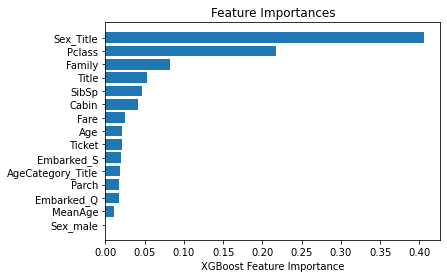

In [165]:
# Feature Importance
importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [train.columns[i] for i in idxs])
plt.xlabel('XGBoost Feature Importance')
plt.show()

In [148]:
# Based on feature importance
irrelevance = ['Embarked_NONE', 'Fare_bin_3', 'Age_bin_3', 'MeanFare']

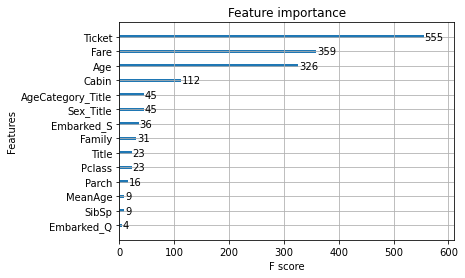

In [166]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
pyplot.show()

In [137]:
corr_matrix = combine.corr()
corr_matrix

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,MeanAge,...,AgeCategory_SexTitle,FareCategory_PClassMap,Cabin_FareCategory,Cabin_PClassMap_FareCategory,Ticket_PClassMap,FareCategory_Ticket_PClassMap,Sex_male,Embarked_NONE,Embarked_Q,Embarked_S
Survived,1.000000,-0.338481,-0.087092,-0.035322,0.081629,-0.166734,0.257307,-0.252403,-0.190488,-0.178090,...,-0.148048,-0.319291,-0.252616,-0.257412,-0.166678,-0.183948,-0.543351,0.060095,0.003650,-0.155660
Pclass,-0.338481,1.000000,-0.377708,0.060832,0.018322,0.309695,-0.558694,0.673654,-0.007861,-0.170118,...,0.241318,0.966540,0.675452,0.688413,0.309641,0.375845,0.124617,-0.060480,0.230491,0.096335
Age,-0.087092,-0.377708,1.000000,-0.220784,-0.138532,-0.088856,0.169181,-0.282968,0.351535,0.577176,...,-0.557068,-0.360586,-0.283451,-0.287483,-0.088755,-0.111954,0.082965,0.059626,-0.049068,-0.047401
SibSp,-0.035322,0.060832,-0.220784,1.000000,0.373587,0.063921,0.160357,0.009731,-0.188333,-0.273513,...,0.125201,0.042225,0.008464,0.010021,0.063758,0.052526,-0.109609,-0.018741,-0.048678,0.075198
Parch,0.081629,0.018322,-0.138532,0.373587,1.000000,0.053389,0.221641,-0.032563,-0.101395,-0.184359,...,0.014657,-0.005089,-0.034038,-0.033138,0.053207,0.026897,-0.213125,-0.017408,-0.100943,0.073258
Ticket,-0.166734,0.309695,-0.088856,0.063921,0.053389,1.000000,-0.014912,0.214208,-0.024515,-0.065463,...,0.055777,0.299492,0.215626,0.219384,0.999994,0.937794,0.024725,-0.059336,0.060143,0.013820
Fare,0.257307,-0.558694,0.169181,0.160357,0.221641,-0.014912,1.000000,-0.521324,-0.072256,-0.014766,...,-0.142010,-0.543667,-0.523164,-0.528245,-0.014909,-0.193623,-0.185693,0.035335,-0.129952,-0.172839
Cabin,-0.252403,0.673654,-0.282968,0.009731,-0.032563,0.214208,-0.521324,1.000000,0.036025,-0.116086,...,0.152767,0.662236,0.999282,0.999068,0.214179,0.290068,0.104394,-0.118986,0.127056,0.168359
Title,-0.190488,-0.007861,0.351535,-0.188333,-0.101395,-0.024515,-0.072256,0.036025,1.000000,0.609060,...,-0.182663,0.005186,0.037723,0.037266,-0.024418,-0.000815,0.227419,-0.005738,-0.134356,0.094613
MeanAge,-0.178090,-0.170118,0.577176,-0.273513,-0.184359,-0.065463,-0.014766,-0.116086,0.609060,1.000000,...,-0.322996,-0.154451,-0.114993,-0.116844,-0.065347,-0.059779,0.144880,-0.002635,-0.132559,0.036839


In [138]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['Cabin_PClassMap', 'MeanAge_bin_30', 'MeanFare_bin_30', 'AgeCategory_SexTitle', 'FareCategory_PClassMap', 'Cabin_FareCategory', 'Cabin_PClassMap_FareCategory', 'Ticket_PClassMap', 'FareCategory_Ticket_PClassMap', 'Sex_male']


In [140]:
combine.drop(to_drop, axis=1, inplace=True)

In [149]:
combine.drop(irrelevance, axis=1, inplace=True)

In [156]:
baseline_combine.columns.values

array(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Title', 'MeanAge', 'MeanFare', 'Sex_male',
       'Embarked_NONE', 'Embarked_Q', 'Embarked_S'], dtype=object)

In [157]:
combine.columns.values

array(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Title', 'MeanAge', 'Family', 'Sex_Title',
       'AgeCategory_Title', 'Embarked_Q', 'Embarked_S'], dtype=object)

In [159]:
combine.loc[:, 'Sex_male'] = baseline_combine.Sex_male

In [164]:
combine.drop('Sex_male', axis=1, inplace=True)

## IMPROVEMENT

In [107]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm', 'rf'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=200,use_best_model=True)
            x_test_predict = self.model.predict(X_test)
            x_train_predict = self.model.predict(X_train)
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict(self.test)
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)
            x_train_predict = self.model.predict(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30,
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict(X_test, num_iteration = self.model.best_iteration_)
            x_train_predict = self.model.predict(X_train, num_iteration = self.model.best_iteration_)
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict(self.test, num_iteration = self.model.best_iteration_)
            return x_test_predict, x_train_predict

        def rf_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train)
            x_test_predict = self.model.predict(X_test)
            x_train_predict = self.model.predict(X_train)
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict(self.test)
            return x_test_predict, x_train_predict

        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'rf': x_test_predict, x_train_predict = rf_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', metric(y_test, x_test_predict))
            print('Training scores', metric(y_train, x_train_predict))
            mean_val.append(metric(y_test, x_test_predict))
            mean_train.append(metric(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(25,20))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

### MODEL 1: CATBOOST

================================Fold1====================================
0:	learn: 0.6888688	test: 0.6893230	best: 0.6893230 (0)	total: 27.3ms	remaining: 54.5s
200:	learn: 0.4202576	test: 0.4591679	best: 0.4591679 (200)	total: 2.99s	remaining: 26.8s
400:	learn: 0.3799163	test: 0.4360759	best: 0.4360759 (400)	total: 6.36s	remaining: 25.4s
600:	learn: 0.3536640	test: 0.4245167	best: 0.4245167 (600)	total: 9.55s	remaining: 22.2s
800:	learn: 0.3333210	test: 0.4181638	best: 0.4181638 (800)	total: 12.8s	remaining: 19.2s
1000:	learn: 0.3185981	test: 0.4147592	best: 0.4147592 (1000)	total: 15.8s	remaining: 15.8s
1200:	learn: 0.3066219	test: 0.4117971	best: 0.4117971 (1200)	total: 18.9s	remaining: 12.6s
1400:	learn: 0.2956164	test: 0.4093377	best: 0.4093377 (1400)	total: 22.1s	remaining: 9.45s
1600:	learn: 0.2862099	test: 0.4080815	best: 0.4079934 (1586)	total: 25.7s	remaining: 6.39s
1800:	learn: 0.2768874	test: 0.4066805	best: 0.4066552 (1798)	total: 28.7s	remaining: 3.17s
1999:	learn: 0.2686

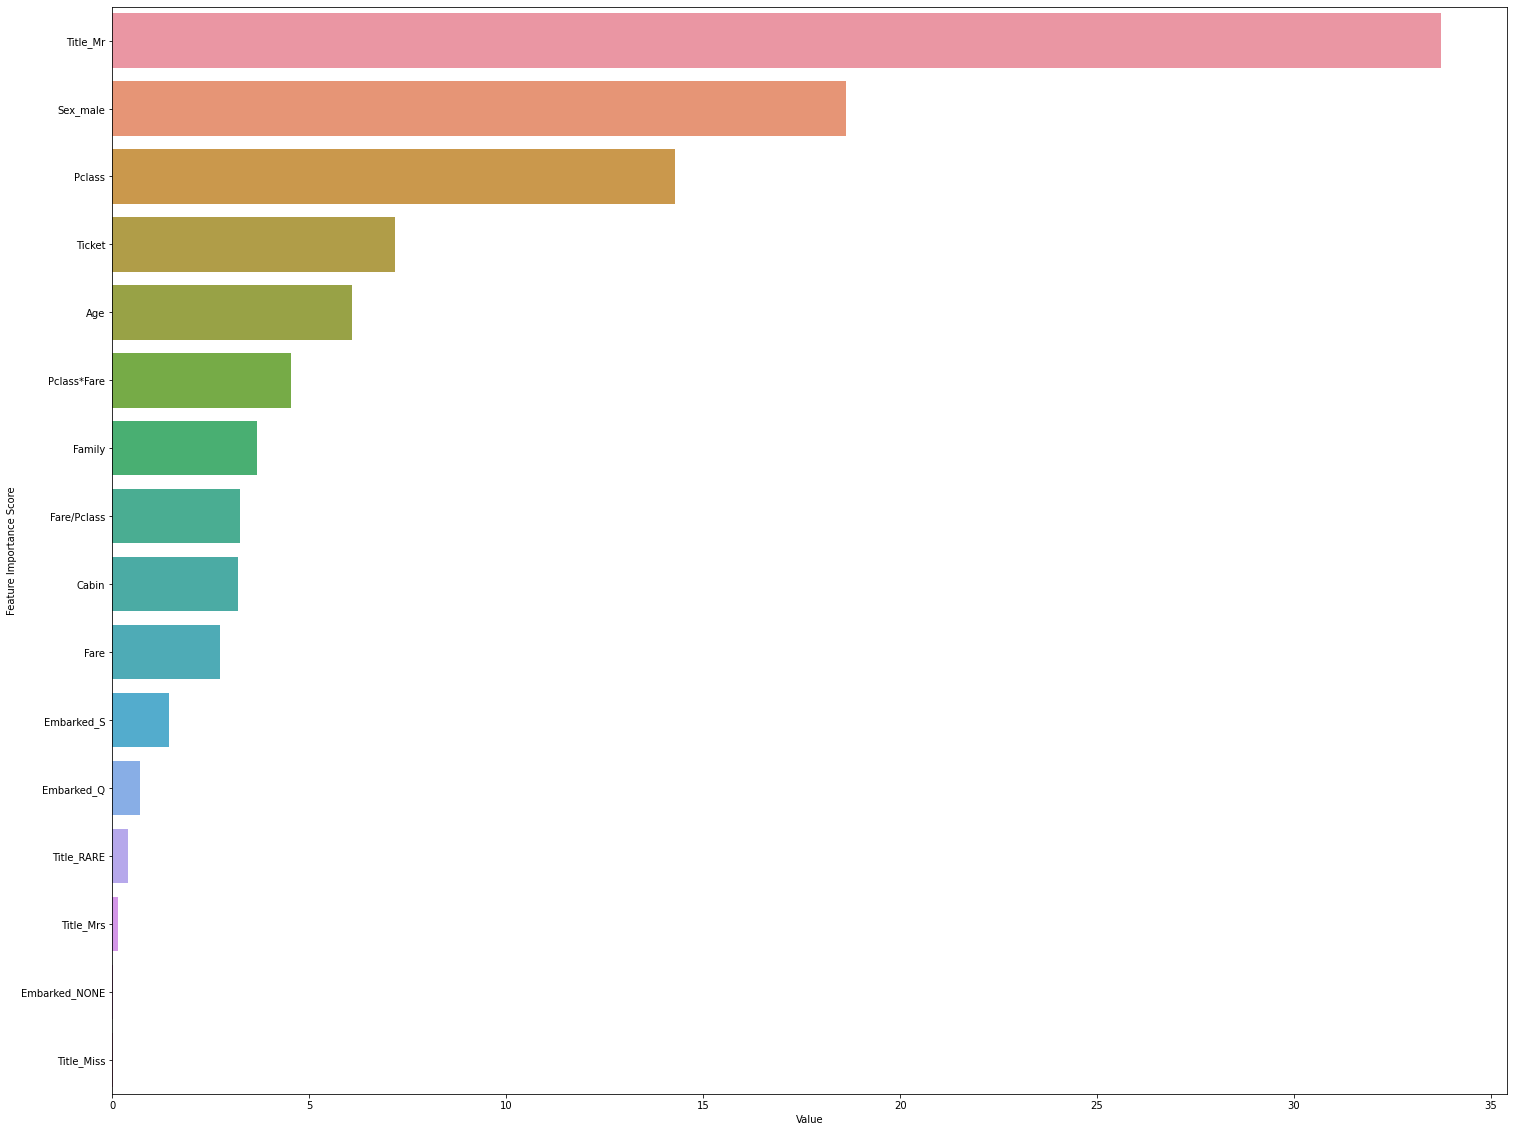

0.8361308141359614 0.9104960839623683 0.0234606894821681


In [111]:
catboost = cat_.CatBoostClassifier(n_estimators=2000, max_depth=9, reg_lambda = 370)

func_= func(train, target, test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

### MODEL 2: XGBOOST

================================Fold1====================================
[06:01:35] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.84210
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.85922
[2]	validation_0-auc:0.86252
[3]	validation_0-auc:0.86943
[4]	validation_0-auc:0.87055
[5]	validation_0-auc:0.86924
[6]	validation_0-auc:0.86858
[7]	validation_0-auc:0.86779
[8]	validation_0-auc:0.86693
[9]	validation_0-auc:0.86186
[10]	validation_0-auc:0.86173
[11]	validation_0-auc:0.86515
[12]	validation_0-auc:0.86647
[13]	validation_0-auc:0.85896
[14]	validation_0-auc:0.86080
[15]

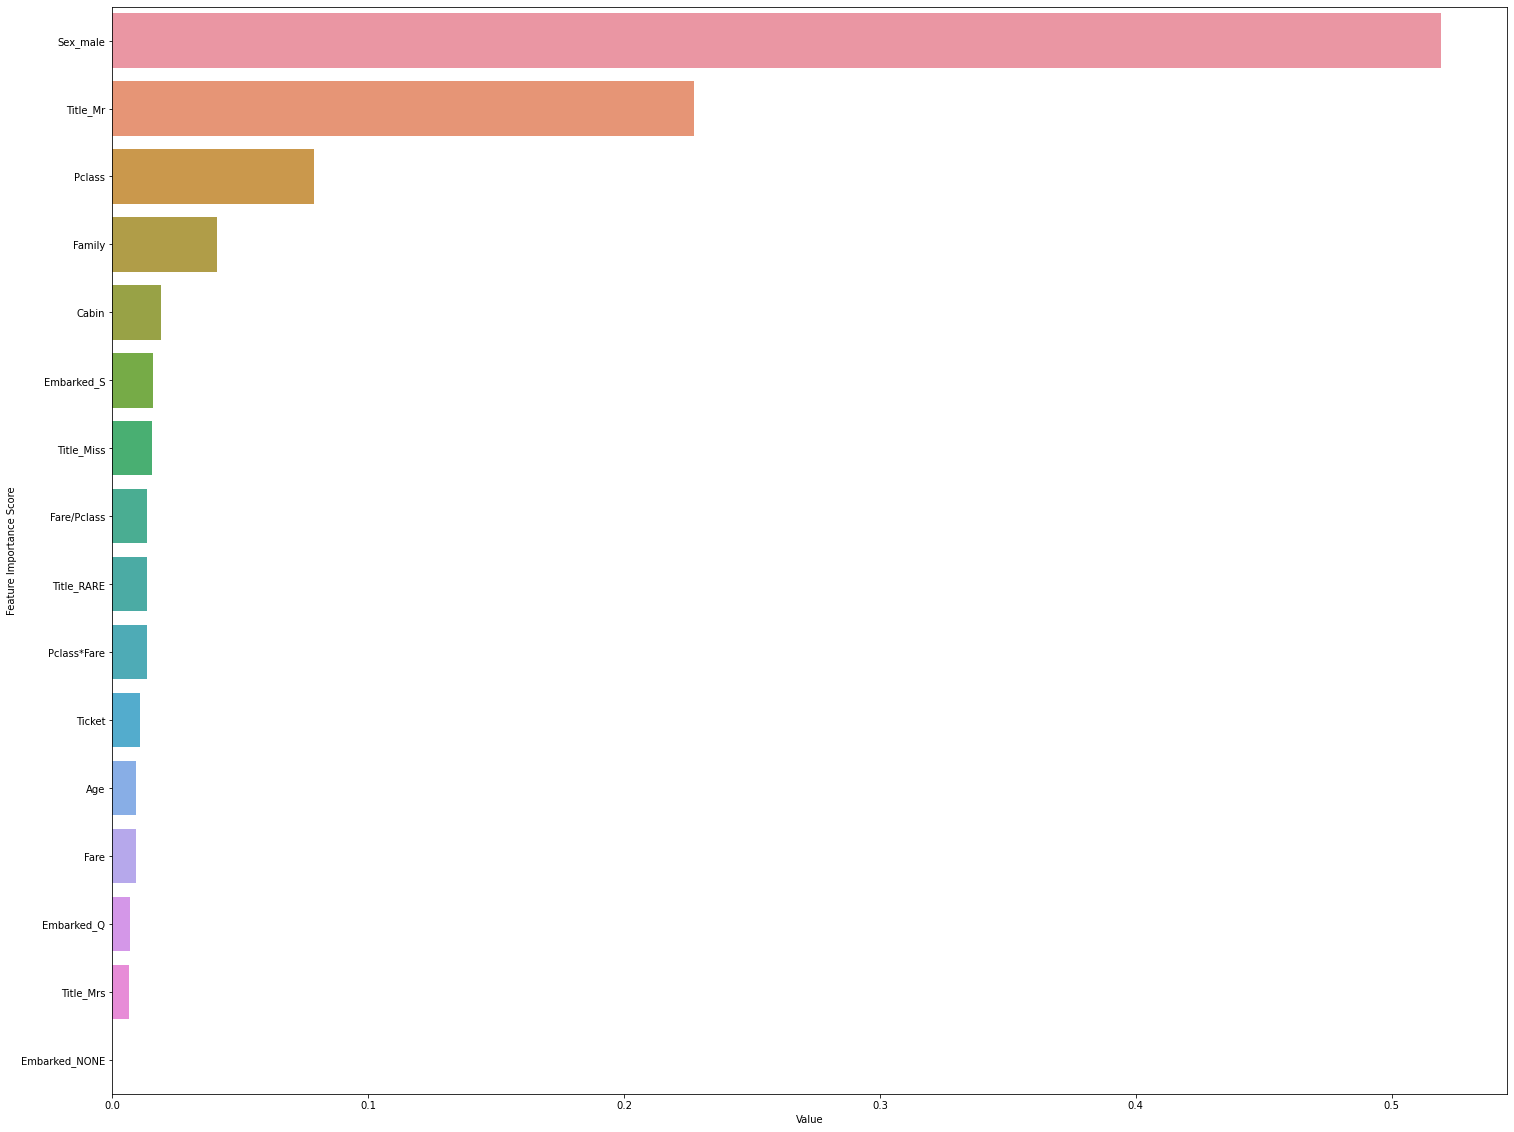

0.8496014060636494 0.8886001544352868 0.014443618231605705


In [90]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 8, 
                          n_estimators = 5000,
                          reg_lambda = 200,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8)
func_= func(train, target, test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

### MODEL 3: LGBM (Unused)

In [98]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            #metric= 'auc',
                            boosting_type= 'gbdt',
                            #lambda_l1= 0.0004912993970392775,
                            #lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            #feature_fraction= 1.0,
                            #bagging_fraction= 0.9540416539312312,
                            #bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(train, target, test, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

================================Fold1====================================
[1]	valid_0's binary_logloss: 0.635925
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.61053
[3]	valid_0's binary_logloss: 0.59022
[4]	valid_0's binary_logloss: 0.571391
[5]	valid_0's binary_logloss: 0.557662
[6]	valid_0's binary_logloss: 0.544097
[7]	valid_0's binary_logloss: 0.533823
[8]	valid_0's binary_logloss: 0.522686
[9]	valid_0's binary_logloss: 0.514072
[10]	valid_0's binary_logloss: 0.507737
[11]	valid_0's binary_logloss: 0.500808
[12]	valid_0's binary_logloss: 0.496506
[13]	valid_0's binary_logloss: 0.491049
[14]	valid_0's binary_logloss: 0.485986
[15]	valid_0's binary_logloss: 0.480576
[16]	valid_0's binary_logloss: 0.477424
[17]	valid_0's binary_logloss: 0.47432
[18]	valid_0's binary_logloss: 0.471924
[19]	valid_0's binary_logloss: 0.470556
[20]	valid_0's binary_logloss: 0.469207
[21]	valid_0's binary_logloss: 0.468159
[22]	valid_0's binary_logloss: 0.4669

LightGBMError: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\python-package\compile\src\treelearner\serial_tree_learner.cpp, line 651 .


### MODEL 4: RANDOM FOREST

================================Fold1====================================

Validation scores 0.8435754189944135
Training scores 0.9508426966292135
================================Fold2====================================

Validation scores 0.8146067415730337
Training scores 0.9621318373071529
================================Fold3====================================

Validation scores 0.8820224719101124
Training scores 0.9424964936886395
================================Fold4====================================

Validation scores 0.8258426966292135
Training scores 0.9495091164095372
================================Fold5====================================

Validation scores 0.8595505617977528
Training scores 0.9438990182328191


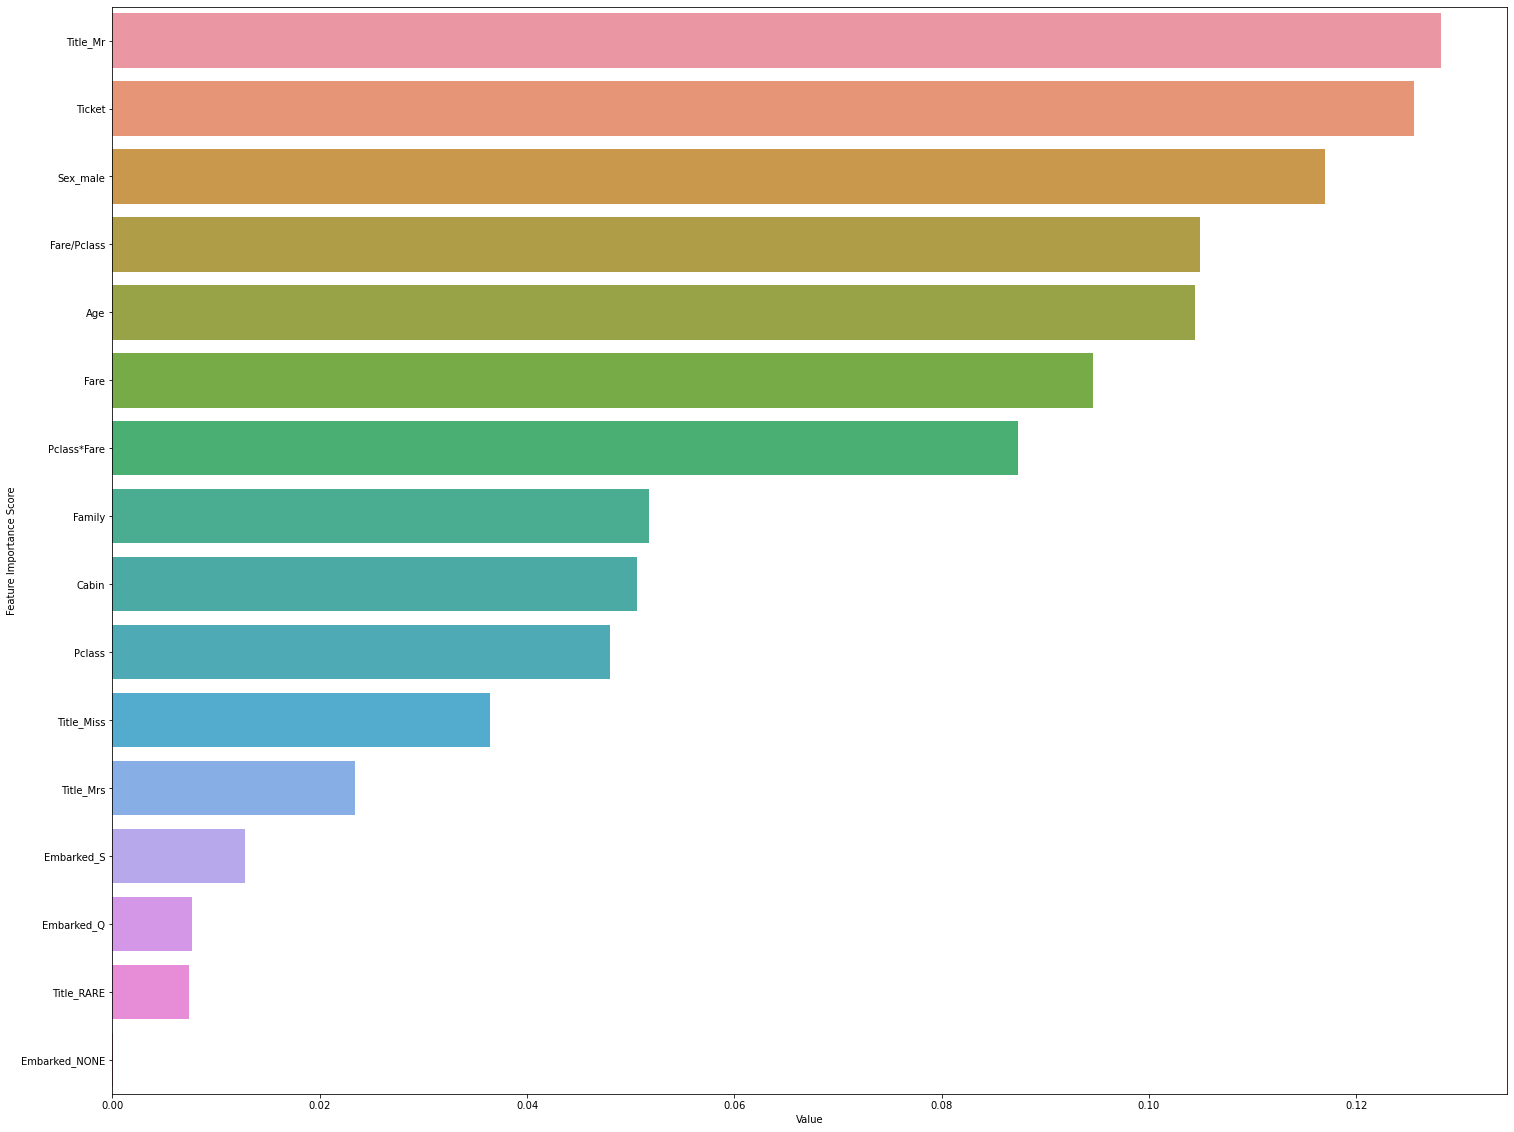

0.8451195781809051 0.9497758324534724 0.023979543955416356


In [110]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=9, criterion='entropy')

func_= func(train, target, test, rf_model, 'rf', 1000)
val_p4, test_p4, model4 = func_()

## Stacking

In [163]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p4))
stack_p = np.column_stack((test_p1, test_p2, test_p4))
predict = LinearRegression().fit(stack, target).predict(stack_p)

In [171]:
predict

array([0.12783024, 0.36675739, 0.12783024, 0.12783024, 0.72406843,
       0.12783024, 0.60434673, 0.12783024, 0.86289304, 0.12783024,
       0.12783024, 0.12783024, 0.86289304, 0.12783024, 0.86289304,
       0.86289304, 0.12783024, 0.12783024, 0.437715  , 0.60501563,
       0.12783024, 0.42628379, 0.86289304, 0.12783024, 0.86289304,
       0.12783024, 0.86289304, 0.12783024, 0.18359712, 0.12783024,
       0.12783024, 0.12783024, 0.80712616, 0.47319381, 0.73174012,
       0.12783024, 0.30656209, 0.29070244, 0.12783024, 0.6246348 ,
       0.12783024, 0.48972236, 0.12783024, 0.86289304, 0.86289304,
       0.12783024, 0.12783024, 0.12783024, 0.86289304, 0.86289304,
       0.73174012, 0.12783024, 0.86289304, 0.86289304, 0.12783024,
       0.12783024, 0.12783024, 0.12783024, 0.12783024, 0.86289304,
       0.12783024, 0.12783024, 0.12783024, 0.86289304, 0.86289304,
       0.86289304, 0.86289304, 0.12783024, 0.46943429, 0.86289304,
       0.86289304, 0.12783024, 0.42185536, 0.50166983, 0.86289

In [172]:
submission = pd.DataFrame({
        'PassengerId': identifier,
        'Survived': thresh(predict, 0.85)
    })
submission.to_csv('titanic_stack_7.csv', index=False)

In [9]:
def thresh(b, c):
    t_list = list()
    for i in b:
        if i > c:
            t_list.append(1)
        else:
            t_list.append(0)
    return t_list